In [79]:
from datetime import date, timedelta
import pandas as pd
import requests

In [ ]:
# Reemplaza 'TU_TOKEN_AQUI' con tu token real de Banxico
# Lo puedes obtener en https://www.banxico.org.mx/SieAPIRest/service/v1/token
BANXICO_API_TOKEN = "c1d2e7873c95abdcfd2ab0924ea74ce68d8e1a5a11d805615a92a488a3a3330b"

# Identificadores para diferentes series de datos
# SF43936: CETES a 28 días
# SF43939: CETES a 91 días
# SF43942: CETES a 182 días
# SP1: INPC
# Vamos a usar la de CETES a 28 días y la del INPC (inflación)
cetes_id = "SF43936"
inpc_id = "SP1"
series = f"{cetes_id},{inpc_id}"

# URL de la API de Banxico para consultar series de tiempo
url = f"https://www.banxico.org.mx/SieAPIRest/service/v1/series/{series}/datos"
headers = {
    'Bmx-Token': BANXICO_API_TOKEN,
    'Accept': 'application/json'
}

In [39]:
response = requests.get(url, headers=headers)
response.json()

{'bmx': {'series': [{'idSerie': 'SP1',
    'titulo': 'IPC Por objeto del gasto                                                         Nacional I n d i c e   G e n e r a l',
    'datos': [{'fecha': '01/01/1969', 'dato': '0.011595000000'},
     {'fecha': '01/02/1969', 'dato': '0.011636000000'},
     {'fecha': '01/03/1969', 'dato': '0.011648000000'},
     {'fecha': '01/04/1969', 'dato': '0.011680000000'},
     {'fecha': '01/05/1969', 'dato': '0.011680000000'},
     {'fecha': '01/06/1969', 'dato': '0.011721000000'},
     {'fecha': '01/07/1969', 'dato': '0.011766000000'},
     {'fecha': '01/08/1969', 'dato': '0.011779000000'},
     {'fecha': '01/09/1969', 'dato': '0.011889000000'},
     {'fecha': '01/10/1969', 'dato': '0.012014000000'},
     {'fecha': '01/11/1969', 'dato': '0.012015000000'},
     {'fecha': '01/12/1969', 'dato': '0.012106000000'},
     {'fecha': '01/01/1970', 'dato': '0.012198000000'},
     {'fecha': '01/02/1970', 'dato': '0.012196000000'},
     {'fecha': '01/03/1970', 'dat

In [56]:
series = response.json()["bmx"]["series"]
series

[{'idSerie': 'SP1',
  'titulo': 'IPC Por objeto del gasto                                                         Nacional I n d i c e   G e n e r a l',
  'datos': [{'fecha': '01/01/1969', 'dato': '0.011595000000'},
   {'fecha': '01/02/1969', 'dato': '0.011636000000'},
   {'fecha': '01/03/1969', 'dato': '0.011648000000'},
   {'fecha': '01/04/1969', 'dato': '0.011680000000'},
   {'fecha': '01/05/1969', 'dato': '0.011680000000'},
   {'fecha': '01/06/1969', 'dato': '0.011721000000'},
   {'fecha': '01/07/1969', 'dato': '0.011766000000'},
   {'fecha': '01/08/1969', 'dato': '0.011779000000'},
   {'fecha': '01/09/1969', 'dato': '0.011889000000'},
   {'fecha': '01/10/1969', 'dato': '0.012014000000'},
   {'fecha': '01/11/1969', 'dato': '0.012015000000'},
   {'fecha': '01/12/1969', 'dato': '0.012106000000'},
   {'fecha': '01/01/1970', 'dato': '0.012198000000'},
   {'fecha': '01/02/1970', 'dato': '0.012196000000'},
   {'fecha': '01/03/1970', 'dato': '0.012232000000'},
   {'fecha': '01/04/1970', '

In [ ]:
len(series)

2

In [57]:
type(series[0])

dict

In [ ]:
for serie in series:
    datos = []
    for dato in serie["datos"]:
        fecha = dato["fecha"]
        valor = dato["dato"]
        try:
            fecha = date.strptime(fecha, "%d/%m/%Y")
            valor = float(valor)
        except ValueError:
            continue
        datos.append((fecha, valor))
    if serie["idSerie"] == inpc_id:
        inpc = datos
    elif serie["idSerie"] == cetes_id:
        cetes = datos      

In [61]:
len(inpc), len(cetes)

(682, 2151)

In [63]:
cetes == sorted(cetes)

True

In [111]:
def buscar(datos, fecha, tope_sup=True):
    """
    Buscar, para una fecha dada, el valor correspondiente, en una lista de tuplas.
    El primer elemento de la tupla es la fecha, el segundo el valor.
    Las fechas se encuentran ordenadas de manera ascendente.
    Si no se encuentra la fecha exacta, se regresa el valor correspondiente a la fecha
    inmediatamente anterior (mayor fecha que sea menor o igual a la buscada).
    Si la fecha no se encuentra dentro del intervalo cubierto por la lista, regresa None,
    a menos que tope_sup sea False, en cuyo caso, regresa el último valor de la lista
    (correspondiente a la fecha más reciente).
    """
    for (f1, v1), (f2, v2) in zip(datos[:-1], datos[1:]):
        if f1 <= fecha < f2:
            valor = v1
            break
        if f1 > fecha:
            # Ya nos pasamos
            valor = None
            break
    else:
        if tope_sup:
            valor = None
        else:
            valor = v2
    return valor

In [134]:
def valoracion(portafolio, fecha):
    """
    Devuelve el valor actual de un portafolio (a la fecha indicada).
    Un portafolio es una lista de inversiones, donde cada inversión se
    representa como se describe más adelante.
    """
    valor_total = 0
    for inversion in portafolio:
        valor_total += valor(inversion, fecha)
    return valor_total

def valor(inversion, fecha):
    """
    Devuelve el valor actualizado de una inversión a una fecha dada.
    La inversión se representa mediante un diccionario con claves: monto, tasa, vencimiento y plazo.
    """
    valor_inicial = inversion["monto"]
    tasa_diaria = inversion["tasa"] / 100 / 360
    if fecha >= inversion["vencimiento"]:
        tasa_efectiva = tasa_diaria * inversion["plazo"]
    else:
        dias_transcurridos = inversion["plazo"] - (inversion["vencimiento"] - fecha).days
        tasa_efectiva = tasa_diaria * dias_transcurridos
    valor_final = valor_inicial * (1 + tasa_efectiva)
    return inversion["monto"] * (1 + inversion["tasa"] / 100 / 360 * inversion["plazo"])

In [101]:
"""
Estrategia de inversión:

- Meter a CETES el equivalente a $100 actuales cada martes durante 40 años.
- Comenzar en el primer martes de hace 40 años.
- Si no existe dato de CETES para esa fecha, brincársela.

Nota: Los CETES se subastan en martes, pero en la tabla vienen reportados al jueves (¡?)
"""

inversion_semanal = 100
# 01/ene de hace 40 años
fecha_inicial = date(date.today().year - 40, 1, 1)
# Moverlo al martes
dia_semana = fecha_inicial.weekday() # 0: lunes, 1: martes, ...
dias = (3 - dia_semana + 7) % 7
fecha_inicial = fecha_inicial + timedelta(days=dias)
fecha_inicial, fecha_inicial.weekday()

(datetime.date(1985, 1, 3), 3)

In [135]:
fecha = fecha_inicial
inpc_actual = buscar(inpc, date.today(), tope_sup=False)  # El más reciente, aunque no corresponda al mes
portafolio = []
historico = []
invertido = 0
disponible = 0
while fecha <= date.today():
    # Ajustar el depósito semanal por inflación
    inpc_historico = buscar(inpc, fecha, tope_sup=False)
    deposito = inversion_semanal / inpc_actual * inpc_historico
    invertido += deposito
    # Tenemos disponible ese depósito semanal
    disponible += deposito
    # Más cualquier inversión que haya madurado a la fecha
    for inversion in portafolio:
        if inversion["vencimiento"] <= fecha:
            disponible += valor(inversion, fecha)
            inversion["monto"] = 0
    # "Limpiar" el portafolio
    portafolio = [inversion for inversion in portafolio if inversion["monto"] > 0]
    # Comprar CETES
    if (tasa := buscar(cetes, fecha)):
        portafolio.append({
            "monto": disponible,
            "tasa": tasa,
            "plazo": 28,
            "vencimiento": fecha + timedelta(days=28),
        })
        disponible = 0
    # Llevar un registro del comportamiento de la inversión
    historico.append({
        "fecha": fecha,
        "invertido": invertido,
        "valor": valoracion(portafolio, fecha)
    })
    fecha += timedelta(days=7)
# Composición final del portafolio
portafolio

[{'monto': 123036.92290199712,
  'tasa': 7.3,
  'plazo': 28,
  'vencimiento': datetime.date(2025, 12, 4)},
 {'monto': 124253.01817355478,
  'tasa': 7.05,
  'plazo': 28,
  'vencimiento': datetime.date(2025, 12, 11)},
 {'monto': 125846.55190505725,
  'tasa': 7.25,
  'plazo': 28,
  'vencimiento': datetime.date(2025, 12, 18)}]

In [136]:
historico

[{'fecha': datetime.date(1985, 1, 3),
  'invertido': 0.3547513196149829,
  'valor': 0.3711408305811951},
 {'fecha': datetime.date(1985, 1, 10),
  'invertido': 0.7095026392299658,
  'valor': 0.7422816611623902},
 {'fecha': datetime.date(1985, 1, 17),
  'invertido': 1.0642539588449487,
  'valor': 1.1134224917435853},
 {'fecha': datetime.date(1985, 1, 24),
  'invertido': 1.4190052784599316,
  'valor': 1.4845633223247805},
 {'fecha': datetime.date(1985, 1, 31),
  'invertido': 1.7737565980749146,
  'valor': 1.8728508592788269},
 {'fecha': datetime.date(1985, 2, 7),
  'invertido': 2.143245970587405,
  'valor': 2.2765573471742453},
 {'fecha': datetime.date(1985, 2, 14),
  'invertido': 2.5127353430998953,
  'valor': 2.680263835069664},
 {'fecha': datetime.date(1985, 2, 21),
  'invertido': 2.8822247156123857,
  'valor': 3.083970322965083},
 {'fecha': datetime.date(1985, 2, 28),
  'invertido': 3.251714088124876,
  'valor': 3.495834250026787},
 {'fecha': datetime.date(1985, 3, 7),
  'invertido': 

In [141]:
# Valor actual del portafolio
f"{valoracion(portafolio, date.today()):,.2f}"


'375,226.02'

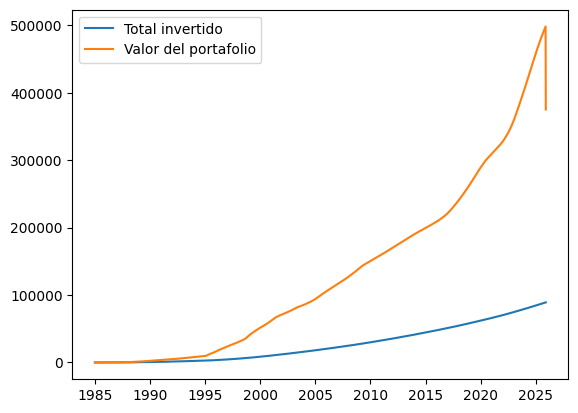

In [145]:
import matplotlib.pyplot as plt

fechas = [dato["fecha"] for dato in historico]
invertido = [dato["invertido"] for dato in historico]
valor = [dato["valor"] for dato in historico]

plt.plot(fechas, invertido, label="Total invertido")
plt.plot(fechas, valor, label="Valor del portafolio")
plt.legend()
plt.show()

In [98]:
inpc[-3:]

[(datetime.date(2025, 8, 1), 140.867),
 (datetime.date(2025, 9, 1), 141.197),
 (datetime.date(2025, 10, 1), 141.708)]

In [92]:
cetes[-3:]

[(datetime.date(2025, 11, 13), 7.05),
 (datetime.date(2025, 11, 20), 7.25),
 (datetime.date(2025, 11, 27), 7.15)]